# Matrix factorization
## System of equations solving
---

Let´s consider the following sistem of $n$ linear equations with $n$ variables:

$$A\mathbf{x} = \begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{pmatrix} \begin{pmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{pmatrix}= \begin{pmatrix}
b_1 \\
b_2 \\
\vdots \\
b_n
\end{pmatrix} =\mathbf{b}$$

where $A\in\mathbb{R}^{n\times n}$ and $\mathbf{x},\mathbf{b}\in \mathbb{R}^n$. For small matrices, there are convenient methods that can be used directly to find the values ​​of the variables. However, when the size ($n$) increases significantly, it becomes difficult to determine whether a system has a solution and, if so, to find it. For this reason, several mathematicians found ways to factor the system in order to simplify it. In this notebook, I will develop some of these methods, along with their computational implementation programmed from scratch, since within data science we can find various situations (when making predictions, forecasts, and regressions) in which it is necessary to solve one of these problems quickly and with the least possible error.

### Libraries

In [41]:
import numpy as np
from scipy.linalg import lu
import math as mt
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import time

### LU factorization

A first approach involves finding two matrices $L, U \in\mathbb{R}^{n\times n}$ such that $A = LU$, $L$ is a lower triangular matrix and $U$, on the contrary, is an upper triangular matrix. Thus, our system becomes $L\mathbf{y} = \mathbf{b}$, where $U\mathbf{x}=\mathbf{y}$. The main requirement for this factorization to exist is that $A$ must be strictly invertible. Its operation is approximately as follows:

In [32]:
def LU_factorization(A):
    """
    Function that finds LU factorization through Doolittle method.

    inputs:
    --------
        A - NumPy array: Matrix to be factored. It must be square and invertible (with a determinant other than 0).

    outputs:
    --------
        L - NumPy array: Lower triangular matrix of the factorization. This matrix has 1s on the diagonal.
        U - NumPy array: Upper triangular matrix of the factorization.
    """
    m, n = A.shape
    if m != n:
        raise ValueError("Matrix must be square.")
    L = np.eye(m, n)
    U = np.zeros((m, n))

    for i in range(n):
        for j in range(i, n):
            sum_ = 0.0
            for k in range(i):
                sum_ += L[i][k] * U[k][j]
            U[i][j] = A[i][j] - sum_
        for j in range(i+1, n):
            sum_ = 0.0
            for k in range(i):
                sum_ += L[j][k] * U[k][i]
            if abs(U[i][i]) < 1e-16:
                raise ValueError("Matrix must be invertible.")
            else:
                L[j][i] = (A[j][i] - sum_) / U[i][i]
    return L, U


### PLU factorization

Note that the previous solution has a drawback: If `U[i][i]` is very small (or even 0), the factorization could result in an error or return very large numbers in the inputs of the factored matrices, implying a high computational cost. Therefore, it is convenient for the diagonal elements of the original matrix to be the largest available. Thus, we can permute the rows using a matrix $P$ before performing the factorization, modifying the previous logic to $A=PLU$:

In [33]:
def PLU_factorization(A):
    """
    Function that finds PLU factorization through gaussian elimination.

    inputs:
    --------
        A - NumPy array: Matrix to be factored. It must be square and invertible (with a determinant other than 0).

    outputs:
    --------
        P - NumPy array: Permutation matrix
        L - NumPy array: Lower triangular matrix of the factorization. This matrix has 1s on the diagonal.
        U - NumPy array: Upper triangular matrix of the factorization.    
    """
    m, n = A.shape
    if m != n:
        raise ValueError("Matrix must be square.")
    U = A.copy().astype(float)
    L = np.eye(n)
    P = np.eye(n)

    for k in range(n-1):
        max_index = np.argmax(np.abs(U[k:, k])) + k
        if max_index != k:
            U[[k, max_index], k:] = U[[max_index, k], k:]
            P[[k, max_index]] = P[[max_index, k]]
            if k > 0:
                L[[k, max_index], :k] = L[[max_index, k], :k]
        if abs(U[k, k]) < 1e-15:
            raise ValueError("The matrix is ​​singular, it cannot be factored.")
        rows = slice(k+1, n)
        L[rows, k] = U[rows, k] / U[k, k]
        changes = L[rows, k].reshape(-1, 1) * U[k, k:]
        U[rows, k:] -= changes
    return P, L, U

Within the linear algebra tools of `SciPy`, we can find an implementation of this factorization. We can then compare our result with that of Python:

In [34]:
A = np.random.rand(4, 4)
P, L, U = PLU_factorization(A)
P_s, L_s, U_s = lu(A)
print("Original matrix:")
print(A)
print("\nFactorization from scratch:")
print("P = ", P, "\nL = ", L, "\nU = ", U)
print("\nSciPy factorization:")
print("P = ", P_s, "\nL = ", L_s, "\nU = ", U_s)
print("\nOur error: ", np.linalg.norm(A - P @ L @ U))
print("\nSciPy error: ", np.linalg.norm(A - P.T @ L_s @ U_s))


Original matrix:
[[0.39644495 0.14391793 0.86300316 0.33108282]
 [0.54883781 0.8714157  0.52428543 0.98869495]
 [0.24565935 0.26603557 0.37166966 0.17454588]
 [0.99562306 0.29208999 0.08868264 0.09237023]]

Factorization from scratch:
P =  [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]] 
L =  [[1.         0.         0.         0.        ]
 [0.55125061 1.         0.         0.        ]
 [0.39818779 0.03886715 1.         0.        ]
 [0.24673931 0.27303665 0.27185264 1.        ]] 
U =  [[ 9.95623060e-01  2.92089988e-01  8.86826438e-02  9.23702275e-02]
 [ 0.00000000e+00  7.10400915e-01  4.75399072e-01  9.37775807e-01]
 [ 0.00000000e+00  0.00000000e+00  8.09213402e-01  2.57853452e-01]
 [ 0.00000000e+00  0.00000000e+00  2.77555756e-17 -1.74390788e-01]]

SciPy factorization:
P =  [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]] 
L =  [[1.         0.         0.         0.        ]
 [0.55125061 1.         0.         0.        ]
 [0.39818779 0.03886715 1.         0.    

Although our error is slightly larger, this approach allows us to reinforce the concept and procedures for obtaining the factorization. We can reduce it through other methods and factorizations.

### Cholesky factorization

Our next approach, proposed by the French mathematician André-Louis Cholesky, starts from a similar idea: two triangular matrices. However, in this case, we seek to find one matrix to be the transpose of the other: that is, to find $L\in\mathbb{R}^{n\times n}$ such that $A = LL^t$. For this to be possible, it is not enough for $A$ to be square; it must also be symmetric and positive definite. We can program the steps of the algorithm as follows:

In [35]:
def Cholesky_factorization(A):
    """
    Function that finds Cholesky (LL^T) factorization.

    inputs:
    --------
        A - NumPy array: Matrix to be factored. It must be square and invertible (with a determinant other than 0).

    outputs:
    --------
        L - NumPy array: Lower triangular matrix of the factorization.
    """
    m, n = A.shape
    if m != n:
        raise ValueError("Matrix must be square.")
    if not np.allclose(A, A.T): 
        raise ValueError("Matrix must be symmetric.")
    
    L = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            square_sum = 0.0
            for k in range(j):
                square_sum += L[i][k] * L[j][k]
            if i == j:
                root_value = A[i][i] - square_sum
                if root_value <= 1e-16:
                    raise ValueError("Matrix must be positive definite.")
                L[i][j] = mt.sqrt(root_value)
            else:
                if L[j][j] == 0:
                    raise ValueError("Matrix must be positive definite.")
                L[i][j] = (A[i][j] - square_sum) / L[j][j]
    return L

Again, we can consider the implementation already included with `NumPy` to verify the performance of ours:

In [40]:
a = np.random.rand(4, 4)
A = a @ a.T
L = Cholesky_factorization(A)
L_n = np.linalg.cholesky(A)
print("Original matrix:")
print(A)
print("\nFactorization from scratch:")
print("L = ", L)
print("\nNumPy factorization:")
print("L = ", L_n)
print("\nOur error: ", np.linalg.norm(A - L @ L.T))
print("\nNumPy error: ", np.linalg.norm(A - L_n @ L_n.T))

Original matrix:
[[1.90421378 0.47752639 0.73084394 0.7364018 ]
 [0.47752639 0.25251092 0.29188173 0.25108636]
 [0.73084394 0.29188173 0.90129889 0.48307096]
 [0.7364018  0.25108636 0.48307096 0.36021031]]

Factorization from scratch:
L =  [[1.37993253 0.         0.         0.        ]
 [0.34605053 0.36436238 0.         0.        ]
 [0.52962296 0.29806981 0.72935095 0.        ]
 [0.53365058 0.18228086 0.20032186 0.04552153]]

NumPy factorization:
L =  [[1.37993253 0.         0.         0.        ]
 [0.34605053 0.36436238 0.         0.        ]
 [0.52962296 0.29806981 0.72935095 0.        ]
 [0.53365058 0.18228086 0.20032186 0.04552153]]

Our error:  1.5700924586837752e-16

NumPy error:  1.5700924586837752e-16


The performance of the designed algorithm is, in fact, quite surprising in this case. The main disadvantage of this factorization method is the prerequisites for its application.

### Method evaluation

To find out which factorization method is the most efficient, let's try to find the error for matrices of different sizes: From matrices of $2\times 2$ to $200\times 200$:

In [37]:
def compute_error(args):
    """
    Function that calculates the reconstruction error according to the factorization method

    inputs:
    --------
        n - int: Matrix dimension 
        method - str: Method to use

    outputs:
    --------
        n - int: Matrix dimension
        error - float: Approximation difference
    """
    n, method = args
    if n % 40 == 0 :
        print(f"Processing the {n}x{n} matrix with {method.upper()} factorization...")

    if method == "cholesky":
        a = np.random.randn(n, n)
        A = a.T @ a
        L = Cholesky_factorization(A)
        A_hat = L @ L.T

    elif method == "lu":
        A = np.random.randn(n, n)
        L, U = LU_factorization(A)
        A_hat = L @ U

    else:
        A = np.random.randn(n, n)
        P, L, U = PLU_factorization(A)
        A_hat = P.T @ L @ U

    error = np.linalg.norm(A - A_hat, ord="fro")
    return n, error

def run_method(method, sizes):
    """
    Support function for concurrent error computation

    inputs:
    --------
        method - str: Method to use
        sizes - list: Range of test dimensions

    outputs:
    --------
        NumPy array: Results according to each dimension
    """
    tasks = [(n, method) for n in sizes]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_error, tasks))
    return np.array(results)

if __name__ == "__main__":
    sizes = list(range(2, 201))
    start = time.time()
    lu_errors = run_method("lu", sizes)
    end_lu = time.time()
    print("\nTime required for LU factorization calculation:", round(end_lu - start, 2), "s\n")
    plu_errors = run_method("plu", sizes)
    end_plu = time.time()
    print("\nTime required for PLU factorization calculation:", round(end_plu - end_lu, 2), "s\n")
    cholesky_errors = run_method("cholesky", sizes)
    end_cholesky = time.time()
    print("\nTime required for Cholesky factorization calculation:", round(end_cholesky - end_plu, 2), "s\n")
    end = time.time()
    print("Total time spent:", round(end - start, 2), "s")

Processing the 40x40 matrix with LU factorization...
Processing the 80x80 matrix with LU factorization...
Processing the 120x120 matrix with LU factorization...
Processing the 160x160 matrix with LU factorization...
Processing the 200x200 matrix with LU factorization...

Time required for LU factorization calculation: 118.21 s

Processing the 40x40 matrix with PLU factorization...
Processing the 80x80 matrix with PLU factorization...
Processing the 120x120 matrix with PLU factorization...
Processing the 160x160 matrix with PLU factorization...
Processing the 200x200 matrix with PLU factorization...

Time required for PLU factorization calculation: 2.92 s

Processing the 40x40 matrix with CHOLESKY factorization...
Processing the 80x80 matrix with CHOLESKY factorization...
Processing the 120x120 matrix with CHOLESKY factorization...
Processing the 160x160 matrix with CHOLESKY factorization...
Processing the 200x200 matrix with CHOLESKY factorization...

Time required for Cholesky factori

The superior performance of PLU factorization is undeniable: It took approximately 3 seconds to calculate the factorization for the 188 matrices, which is remarkable compared to the 120 seconds of LU. Let's now graphically evaluate the accumulated errors:

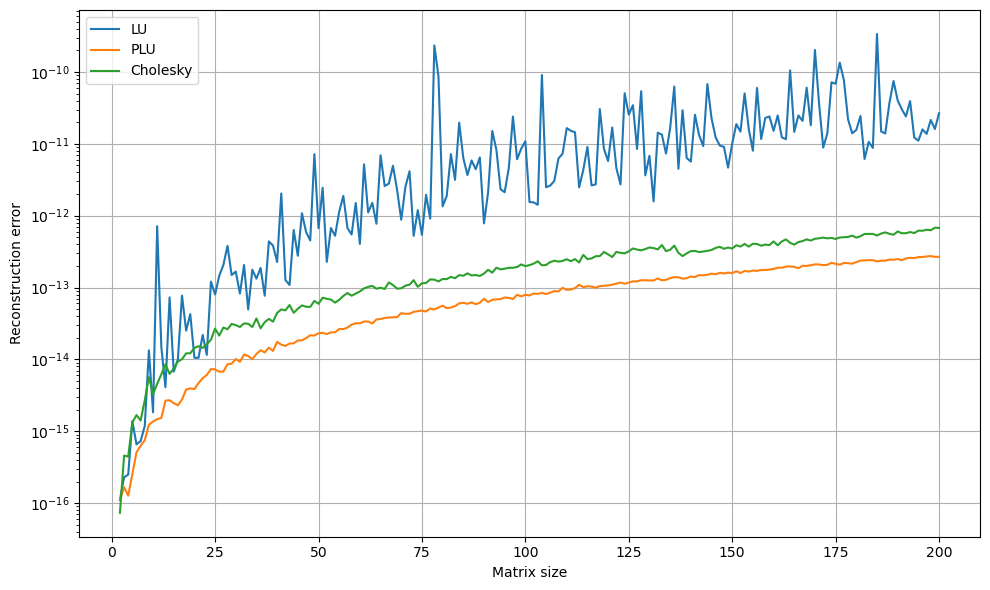

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(lu_errors[:, 0], lu_errors[:, 1], label="LU")
plt.plot(plu_errors[:, 0], plu_errors[:, 1], label="PLU")
plt.plot(cholesky_errors[:, 0], cholesky_errors[:, 1], label="Cholesky")
plt.yscale("log")
plt.xlabel("Matrix size")
plt.ylabel("Reconstruction error")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

We can see that PLU still has the advantage: It has surprising stability and minimal overall errors. In contrast, LU is quite unstable, with some matrices showing twice the error.